# prediction with implicit

## autoreload

In [1]:
%load_ext autoreload
%autoreload 2

## dir setup

In [95]:
from dotenv import load_dotenv, find_dotenv
import os

this_file_path = os.path.dirname(os.path.abspath("__file__"))
# if script (not notebook)...
# project_dir = os.path.join(os.path.dirname(__file__), os.pardir)

# project directory
project_dir = os.path.join(this_file_path, os.pardir)

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [99]:
raw_data_dir = os.path.join(project_dir, os.environ.get("RAW_DATA_DIR"))
processed_data_dir = os.path.join(project_dir, os.environ.get("PROCESSED_DATA_DIR"))
figures_dir = os.path.join(project_dir, os.environ.get("FIGURES_DIR"))
reports_dir = os.path.join(project_dir, os.environ.get("REPORTS_DIR"))
cv_dir = os.path.join(project_dir, os.environ.get("CV_DIR"))

## imports

In [4]:
import numpy as np
from datetime import datetime

In [5]:
import pandas as pd
# pd.set_option('max_rows', None)
# pd.set_option('max_columns', None)
# pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
from tqdm import tqdm
tqdm.pandas()

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [7]:
import scipy.sparse as sparse
import implicit

In [8]:
from sklearn.metrics import ndcg_score

In [33]:
from sklearn.model_selection import ParameterGrid

In [30]:
import mlflow

## project imports

In [9]:
import sys
sys.path.insert(0, '..')

In [54]:
from src.features import *
from src.models import *

* remove buy events: no additional relevance attributed to buy
* remove event timestamp: no additional relevance attributed to recency
* remove search events: no additional relevance attributed to search
* aggregates counts - higher relevance attributed to more views

In [118]:
train_fn = 'train_dataset.pkl'
test_fn = 'test_dataset.pkl'
train, test = read_processed(train_fn, test_fn)

In [119]:
true_fn = 'true.pkl'
true_fp = os.path.join(processed_data_dir, true_fn)
true_df = pd.read_pickle(true_fp)

item_data_fn = 'item_data.jl.gz'
item_data = pd.read_json(os.path.join(raw_data_dir, item_data_fn), lines=True)
item_domain = item_data[['item_id', 'domain_id']]

In [120]:
# validation = 0.2 # 0.2: 20% of original train will be test
# keep_train = 0.6  # 0.6: 60% of train for validation

# validation = 0.2 
# keep_train = 0.1  

validation = 0.2 
keep_train = 0.4 

if validation:
    train_red, test_red = shrink_and_split(train, keep_train = keep_train, validation = validation)

train shape: (12412329, 6)
train/test shapes: (3968821, 6) (968708, 5)


In [131]:
# grid = dict(buy_weight = [50, 100, 200],
#             regularization = [0.01, 0.03, 0.1, 0.3],
#             iterations = [10, 15, 20],
#             factors = [32, 64, 128],
#             alpha_val = [50, 100, 200])

grid = dict(buy_weight = [100, 200],
            regularization = [0.01],
            iterations = [15],
            factors = [128, 256],
            alpha_val = [200])

grid

{'buy_weight': [100, 200],
 'regularization': [0.01],
 'iterations': [15],
 'factors': [128, 256],
 'alpha_val': [200]}

In [132]:
len(list(ParameterGrid(grid))) * 15

60

In [ ]:
mlflow.set_experiment('test 0')

for param in ParameterGrid(grid):
    print(param)
    with mlflow.start_run() as run:
        print("MLflow:")
        print("  run_id:",run.info.run_id)
        print("  experiment_id:",run.info.experiment_id)
        
        test_offset, test_shifted_seq_vals, train_test = join_prepare_train_test(train, test, **param)
        model, seq_map, event_info_map, sparse_user_item = fit_implicit_model(train_test, **param)
        pred = predict_implicit_model(model, sparse_user_item, 
                                      seq_map, event_info_map, test_shifted_seq_vals, 
                                      10, test_offset, 
                                      validation = True, true_df = true_df, item_domain = item_domain)
        
        mlflow.log_param('val_keep', {'v': validation, 'k': keep_train})
        # mlflow.log_param('keep_train', keep_train)
        
        pred_fn = 'pred__' + '__'.join([k + '_' + str(v) for k, v in param.items()]) + '.csv'
        pred_fp = os.path.join(cv_dir, pred_fn)
        pred.to_csv(pred_fp)
        
        mlflow.log_params(param)
        mlflow.log_artifact(pred_fp)
        
        mean_ndcg = pred.ndcg.mean()
        ndcg_larger_than_zero = (pred.ndcg > 0).mean()
        
        print('mean ndcg:', mean_ndcg)
        print('ndcg > 0:', ndcg_larger_than_zero)
        
        mlflow.log_metric('mean_ndcg', mean_ndcg)
        mlflow.log_metric('ndcg_gt_0', ndcg_larger_than_zero)


{'alpha_val': 200, 'buy_weight': 100, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: 317995a213dc48d1ab82257b4d25a94e
  experiment_id: 2


  0%|          | 0/30909 [00:00<?, ?it/s]

100%|██████████| 30909/30909 [16:41<00:00, 30.86it/s]


mean ndcg: 0.38966928505298243
ndcg > 0: 0.4890808502377948
{'alpha_val': 200, 'buy_weight': 100, 'factors': 256, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: ef72e8ef53b74dbe989c7efbbbd3ec50
  experiment_id: 2


100%|██████████| 30909/30909 [26:45<00:00, 19.25it/s]


mean ndcg: 0.4002695315670321
ndcg > 0: 0.5062279594939985
{'alpha_val': 200, 'buy_weight': 200, 'factors': 128, 'iterations': 15, 'regularization': 0.01}
MLflow:
  run_id: 43632b9ea2be49d7afdfcf9dfd05d3ce
  experiment_id: 2


In [56]:
pred.drop('top_score', axis = 1, inplace = True)

In [53]:
unique_seqs_test = test.seq.unique().shape[0] #177070

In [54]:
pred = pred.reindex(index = range(unique_seqs_test))

In [47]:
top_sellers = list(train[train.event_type.isnull()].item_bought.value_counts().head(10).index.astype(int))

In [62]:
pred[pred[0].isnull()] = top_sellers

In [69]:
# pred_5_fn = 'pred_5_implicit.csv'
# pred_5_fp = os.path.join(reports_dir, pred_5_fn)
# pred.to_csv(pred_5_fp, header = None, index = None)

____

### implicit preds & merging with baseline preds - format for submission

* mediana dos top_score é 0.22
* 3o. quartil em 0.602
* utilizando implicit apenas quando o top_score é maior que 0.22 ou 0.602

In [354]:
pred_implicit = pred[pred.top_score > 0.602]

In [355]:
pred_implicit.drop([10, 11, 12, 13, 14, 'top_score'], axis = 1, inplace = True)
# pred_implicit.drop('top_score', axis = 1, inplace = True)

/Users/hitoshinagano/.virtualenvs/tensorflow2/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [373]:
def build_base_pred(df, normalize = False, return_tall = False):
    pred = df[df.event_type == 'view']
    pred = pred.groupby('seq').event_info.value_counts(normalize = normalize)
    pred.name = 'counts'
    pred = pred.reset_index()
    pred['rank'] = pred.groupby('seq')['counts'].transform(lambda x: range(len(x)))
    pred = pred[pred['rank'] < 10]
    if return_tall:
        return pred
    pred = pred.pivot(index = 'seq', columns = 'rank', values = 'event_info')
    return pred

In [359]:
pred_1 = build_base_pred(test)
pred_1 = pred_1.drop(pred_implicit.index)

In [360]:
pred_implicit = pd.concat([pred_implicit, pred_1])
pred_implicit.sort_index(inplace = True)

In [362]:
pred_implicit_list = pred_implicit.apply(list, axis = 1)
pred_to_fill = pred[range(10)].apply(list, axis = 1)
pred_implicit = pd.concat([pred_implicit_list, pred_to_fill], axis = 1)

pred_implicit['event_info'] = pred_implicit[0] + pred_implicit[1]
pred_implicit.drop([0, 1], axis = 1, inplace = True)

pred_implicit['event_info'] = pred_implicit.event_info.apply(lambda x: pd.Series(x).dropna().drop_duplicates().to_list())

pred_implicit = pred_implicit.event_info.apply(pd.Series)
pred_implicit = pred_implicit[range(10)].astype(int)

In [363]:
top_sellers = list(train[train.event_type.isnull()].item_bought.value_counts().head(10).index)

no_views_idxs = pd.Index(range(177070)).difference(pred_implicit.index)
no_views = pd.DataFrame([top_sellers] * len(no_views_idxs), index = no_views_idxs)

pred_implicit = pd.concat([no_views, pred_implicit])

pred_implicit.sort_index(inplace = True)

pred_implicit = pred_implicit.astype(int)

In [365]:
pred_4_fn = 'pred_4_implicit.csv'
pred_4_fp = os.path.join(reports_dir, pred_4_fn)
pred_implicit.to_csv(pred_4_fp, header = None, index = None)

____

In [374]:
pred_1 = build_base_pred(test, normalize = True, return_tall = True)

In [375]:
pred_1

,seq,event_info,counts,rank
0,0,1572239,0.818182,0.0
1,0,685656,0.090909,1.0
2,0,1194894,0.090909,2.0
3,1,943786,0.312500,0.0
4,1,831243,0.187500,1.0
...,...,...,...,...
1448559,177069,389656,0.029412,5.0
1448560,177069,681451,0.029412,6.0
1448561,177069,888769,0.029412,7.0
1448562,177069,987620,0.029412,8.0


____

In [366]:
pred_1_fn = 'pred_1.csv'
pred_1_fp = os.path.join(reports_dir, pred_1_fn)
pred_1 = pd.read_csv(pred_1_fp, header = None)

In [367]:
pred_1

,0,1,2,3,4,5,6,7,8,9
0,1572239,685656,1194894,1194894,1194894,1194894,1194894,1194894,1194894,1194894
1,943786,831243,849692,48097,26324,788705,1125393,1125393,1125393,1125393
2,167018,283306,539599,991246,1219935,1362449,1425647,1614538,1660615,1986443
3,1587422,1587422,1587422,1587422,1587422,1587422,1587422,1587422,1587422,1587422
4,1398419,1398419,1398419,1398419,1398419,1398419,1398419,1398419,1398419,1398419
...,...,...,...,...,...,...,...,...,...,...
177065,24604,24604,24604,24604,24604,24604,24604,24604,24604,24604
177066,331472,524786,765481,1183025,1191685,1384867,1651522,1763050,1907343,1907343
177067,1061535,2033823,136713,246147,273237,1221968,1423904,2093769,2093769,2093769
177068,1803169,1803169,1803169,1803169,1803169,1803169,1803169,1803169,1803169,1803169


In [368]:
(pred_1 == pred_implicit).mean()

0    0.795787
1    0.543401
2    0.431795
3    0.351443
4    0.289648
5    0.241966
6    0.203355
7    0.172587
8    0.147315
9    0.126515
dtype: float64

In [346]:
(pred_1 == pred_implicit).mean()

0    0.588344
1    0.341029
2    0.251522
3    0.193206
4    0.151652
5    0.121715
6    0.099215
7    0.081403
8    0.067781
9    0.056622
dtype: float64

____

In [131]:
set_pred = pred[range(15)].apply(set, axis = 1)
set_pred.name = 'implicit'

In [133]:
pred_1_fn = 'pred_1.csv'
pred_1_fp = os.path.join(reports_dir, pred_1_fn)
pred_1 = pd.read_csv(pred_1_fp, header = None)

In [135]:
set_pred_1 = pred_1.apply(set, axis = 1)
set_pred_1.name = 'pred_1'

In [140]:
compare = pd.concat([set_pred_1, set_pred], axis = 1, join = 'inner')

In [145]:
compare['intersection'] = [set(a) & set(b) for a, b in zip(compare.pred_1, compare.implicit)]

In [149]:
compare['len_intersection'] = compare.intersection.str.len()

In [154]:
compare.len_intersection.value_counts(normalize = True)

0    0.549662
1    0.277200
2    0.106192
3    0.042987
4    0.016506
5    0.005323
6    0.001642
7    0.000416
8    0.000054
9    0.000018
Name: len_intersection, dtype: float64

In [157]:
compare = pd.concat([compare, pred.top_score], axis = 1)

<AxesSubplot:title={'center':'top_score'}, xlabel='len_intersection'>

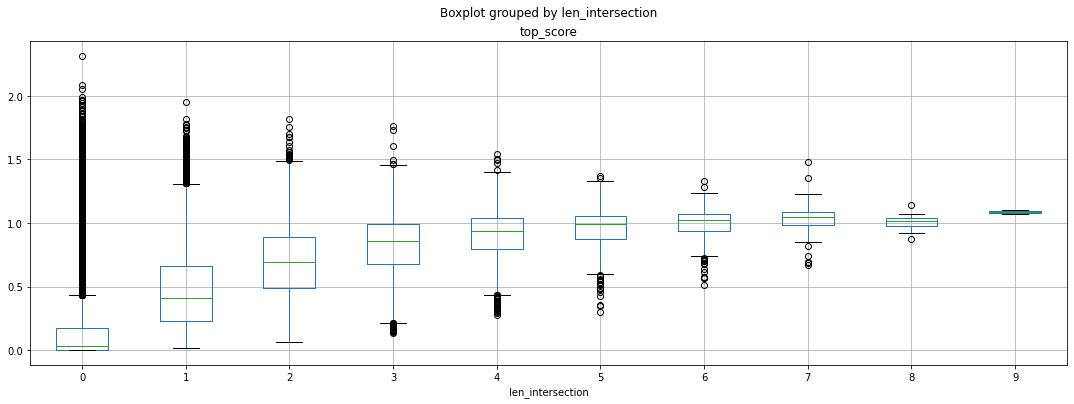

In [162]:
compare.boxplot(column = 'top_score' , by = 'len_intersection', figsize = (18, 6))

In [165]:
recs.top_score.describe(percentiles = (np.arange(0, 1, 0.1))).round(3)

count    2485500.000
mean           0.347
std            0.359
min            0.000
0%             0.000
10%            0.000
20%            0.012
30%            0.047
40%            0.118
50%            0.220
60%            0.353
70%            0.513
80%            0.697
90%            0.913
max            2.316
Name: top_score, dtype: float64

In [166]:
recs.top_score.median()

0.21965806931257248